In [15]:
import os
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from tqdm import tqdm
from PIL import Image
import gc
import time

# Use Agg backend for headless plotting
matplotlib.use('Agg')

import kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold, train_test_split


In [16]:
# Set up parameters
GENRES = [
    "blues", "classical", "country", "disco", "hiphop",
    "jazz", "metal", "pop", "reggae", "rock"
]
SR = 22050
SEGMENT_SECONDS = 5
SEGMENT_SAMPLES = SEGMENT_SECONDS * SR
DATA_ROOT = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
SPEC_ROOT = "./spectrograms"
IMG_SIZE = (224, 224)  # input size for ResNet
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATES = [1e-3, 1e-4]  # Try multiple learning rates
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
K_FOLDS = 5
BEST_MODEL_PATH = "./best_model.pth"
PATIENCE = 5

In [17]:
# Optional audio augmentation
def augment_audio(y, sr):
    y = librosa.effects.time_stretch(y, rate=random.uniform(0.9, 1.1))
    y = librosa.effects.pitch_shift(y, sr=sr, n_steps=random.randint(-2, 2))
    y += np.random.normal(0, 0.005, y.shape)
    return y

# Create full-length spectrograms with both original and augmented audio
def generate_spectrograms():
    for genre in GENRES:
        os.makedirs(f"{SPEC_ROOT}/{genre}", exist_ok=True)
        for i in tqdm(range(100), desc=f"{genre:10s}"):
            file_path = os.path.join(DATA_ROOT, "Data", "genres_original", genre, f"{genre}.000{i:02d}.wav")
            try:
                y, _ = librosa.load(file_path, sr=SR)
                if y is None or len(y) == 0:
                    raise ValueError("Empty audio signal")

                for suffix, audio in zip(["orig", "aug"], [y, augment_audio(y.copy(), SR)]):
                    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SR, n_mels=128)
                    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

                    if mel_db.shape[1] == 0:
                        raise ValueError("Empty spectrogram")

                    fig = plt.figure(figsize=(2.24, 2.24), dpi=100)
                    librosa.display.specshow(mel_db, sr=SR, x_axis=None, y_axis=None)
                    plt.axis('off')
                    plt.tight_layout()
                    filename = f"{genre}_{i:02d}_{suffix}.png"
                    out_path = f"{SPEC_ROOT}/{genre}/{filename}"

                    try:
                        plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
                        if os.path.getsize(out_path) == 0:
                            raise IOError("Output PNG file is 0 bytes")
                    except Exception as e:
                        print(f"Error saving {out_path}: {e}")
                    finally:
                        plt.close(fig)
                        plt.cla()
                        plt.clf()
                        gc.collect()
                        time.sleep(0.05)  # allow WSL to breathe

            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

In [18]:
# ResNet-based model for classification
class SpectrogramResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [17]:
# Check for completeness
def should_generate_spectrograms():
    if not os.path.exists(SPEC_ROOT):
        return True
    for genre in GENRES:
        genre_dir = os.path.join(SPEC_ROOT, genre)
        if not os.path.exists(genre_dir) or len([f for f in os.listdir(genre_dir) if f.endswith('.png')]) < 200:
            return True
    return False

if should_generate_spectrograms():
    print("Generating spectrograms...")
    generate_spectrograms()

In [19]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

full_dataset = datasets.ImageFolder(root=SPEC_ROOT, transform=transform)
targets = [full_dataset[i][1] for i in range(len(full_dataset))]
indices = list(range(len(full_dataset)))

train_val_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=targets, random_state=42)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.1, stratify=[targets[i] for i in train_val_idx], random_state=42)

train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)
test_ds = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

best_val_acc = 0.0
best_config = {}

In [20]:
for lr in LEARNING_RATES:
    print(f"\n=== Trying learning rate: {lr} ===")

    model = SpectrogramResNet(num_classes=len(GENRES)).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    patience_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss / len(train_subset):.4f}")

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        scheduler.step(val_acc)
        print(f"Validation Accuracy: {val_acc:.2%}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_config = {'learning_rate': lr}
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping due to no improvement")
                break

print(f"\nBest Config: {best_config}, Best Validation Accuracy: {best_val_acc:.2%}")


=== Trying learning rate: 0.001 ===


/home/rohan/NNDL/music-genre-classifier/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rohan/NNDL/music-genre-classifier/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Loss: 1.7103
Validation Accuracy: 18.12%
Epoch 2/50, Loss: 1.2956
Validation Accuracy: 25.00%
Epoch 3/50, Loss: 1.0382
Validation Accuracy: 26.25%
Epoch 4/50, Loss: 0.8851
Validation Accuracy: 55.00%
Epoch 5/50, Loss: 0.6654
Validation Accuracy: 56.25%
Epoch 6/50, Loss: 0.5359
Validation Accuracy: 56.88%
Epoch 7/50, Loss: 0.4374
Validation Accuracy: 67.50%
Epoch 8/50, Loss: 0.3581
Validation Accuracy: 57.50%
Epoch 9/50, Loss: 0.3411
Validation Accuracy: 64.38%
Epoch 10/50, Loss: 0.3376
Validation Accuracy: 75.62%
Epoch 11/50, Loss: 0.1563
Validation Accuracy: 78.12%
Epoch 12/50, Loss: 0.1250
Validation Accuracy: 80.00%
Epoch 13/50, Loss: 0.0922
Validation Accuracy: 82.50%
Epoch 14/50, Loss: 0.0665
Validation Accuracy: 78.75%
Epoch 15/50, Loss: 0.1410
Validation Accuracy: 72.50%
Epoch 16/50, Loss: 0.2020
Validation Accuracy: 68.75%
Epoch 17/50, Loss: 0.1195
Validation Accuracy: 80.00%
Epoch 18/50, Loss: 0.0458
Validation Accuracy: 83.75%
Epoch 19/50, Loss: 0.0422
Validation 

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("\n--- Final Test Evaluation ---")
best_model = SpectrogramResNet(num_classes=len(GENRES)).to(DEVICE)
best_model.load_state_dict(torch.load(BEST_MODEL_PATH))
best_model.eval()

correct, total = 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {correct / total:.2%}")

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GENRES)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.savefig("confusion_matrix_resnet.png", bbox_inches="tight")



--- Final Test Evaluation ---
Test Accuracy: 86.50%


In [22]:
# Print the classification report
from sklearn.metrics import classification_report
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=GENRES))


--- Classification Report ---
              precision    recall  f1-score   support

       blues       0.85      0.72      0.78        40
   classical       1.00      0.95      0.97        40
     country       0.97      0.80      0.88        40
       disco       0.97      0.82      0.89        40
      hiphop       0.84      0.78      0.81        40
        jazz       0.90      0.95      0.93        40
       metal       0.87      1.00      0.93        40
         pop       0.76      0.88      0.81        40
      reggae       0.82      0.82      0.82        40
        rock       0.74      0.93      0.82        40

    accuracy                           0.86       400
   macro avg       0.87      0.86      0.87       400
weighted avg       0.87      0.86      0.87       400



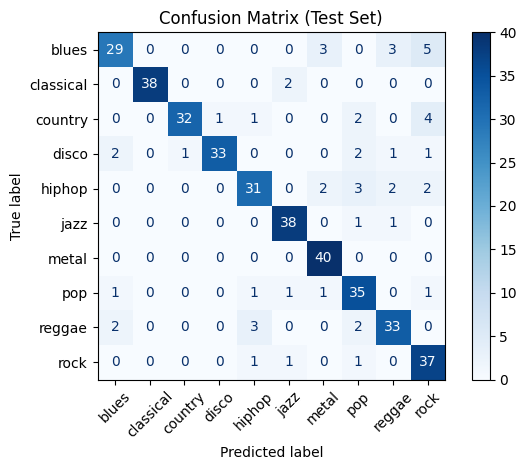

In [23]:
from IPython.display import Image
Image(filename='confusion_matrix_resnet.png')